In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# LOAD the datas

In [23]:
import os
import glob

base_path = '../../mocap_EMG_EEG_data/data_An_Yu/path1_06'
video_path = glob.glob(os.path.join(base_path, 'videos', '*.mp4'))[2]
trc_file_path = glob.glob(os.path.join(base_path, 'opensim', '*.trc'))[0]
trc_output_file_path = f'{base_path}/preprocessing/output/filtered_trc_file.trc'

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames: ", total_frames)
cap.release()

total frames:  979


# Find out the sync marker in the video `.mp4`

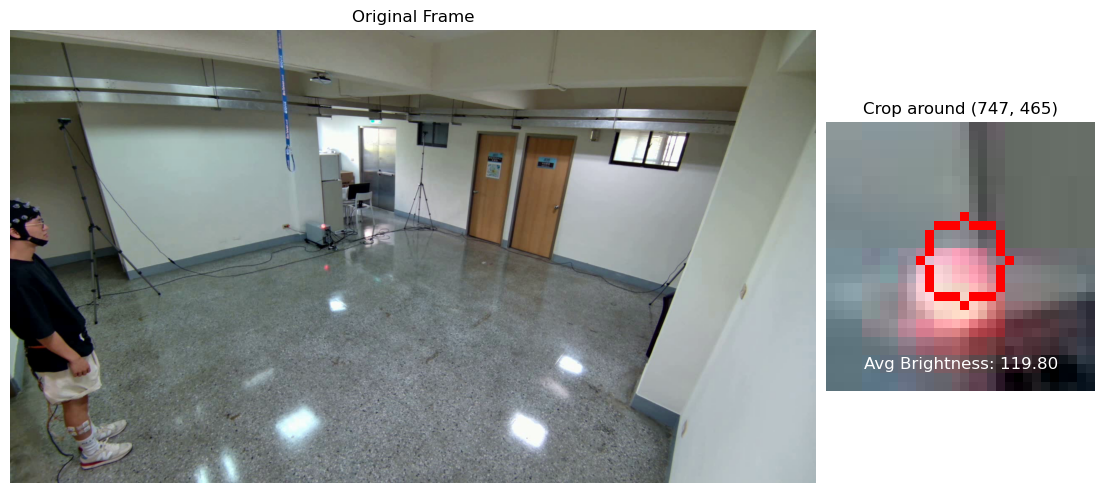

In [36]:
cap = cv2.VideoCapture(video_path)
frame_number = 216
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

lamp_x, lamp_y = 747, 465
half_size = 15
x_start = max(0, lamp_x - half_size)
x_end = min(frame.shape[1], lamp_x + half_size)
y_start = max(0, lamp_y - half_size)
y_end = min(frame.shape[0], lamp_y + half_size)
cropped_frame = frame[y_start:y_end, x_start:x_end]
cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
cropped_frame_gray = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)
avg_brightness = np.mean(cropped_frame_gray)
THRESHOLD = avg_brightness
cropped_lamp_x = lamp_x - x_start
cropped_lamp_y = lamp_y - y_start
cv2.circle(cropped_frame_rgb, (cropped_lamp_x, cropped_lamp_y), radius=5, color=(255, 0, 0), thickness=1)


fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

axs[0].imshow(frame_rgb)
axs[0].set_title('Original Frame')
axs[0].axis('off')
axs[1].imshow(cropped_frame_rgb)
axs[1].set_title(f'Crop around ({lamp_x}, {lamp_y})')
axs[1].axis('off')

axs[1].text(0.5, 0.1, f'Avg Brightness: {avg_brightness:.2f}', color='white',
            fontsize=12, ha='center', va='center', transform=axs[1].transAxes)
plt.subplots_adjust(wspace=0.02)
plt.show()

# the time of start blinking

In [27]:
brightness_values = []
red_values = []
green_values = []
frame_number = 0
max_offset = 30
initial_lamp_x = lamp_x
initial_lamp_y = lamp_y
enable_movement = False
enable_imageShow = True
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        if frame is None:
            print(f"End of video at frame {frame_number}")
        else:
            print(f"Error reading the frame at frame {frame_number}")
        break
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    y_start = max(0, lamp_y - half_size)
    y_end = min(frame.shape[0], lamp_y + half_size)
    x_start = max(0, lamp_x - half_size)
    x_end = min(frame.shape[1], lamp_x + half_size)
    brightness_frame = gray_frame[y_start:y_end, x_start:x_end]

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(brightness_frame)
    if max_val > THRESHOLD and enable_movement:
        new_lamp_x = x_start + max_loc[0]
        new_lamp_y = y_start + max_loc[1]

        if abs(new_lamp_x - initial_lamp_x) > max_offset or abs(new_lamp_y - initial_lamp_y) > max_offset:
            print(f"Error: Lamp moved too far at frame {frame_number}")
            break
        else:
            lamp_x = new_lamp_x
            lamp_y = new_lamp_y
            # print(f"Lamp moved to ({lamp_x}, {lamp_y}) at frame {frame_number}")
        
    avg_brightness = np.mean(brightness_frame)
    brightness_values.append(avg_brightness)

    red_channel = frame[y_start:y_end, x_start:x_end, 2]
    green_channel = frame[y_start:y_end, x_start:x_end, 1]
    avg_red = np.mean(red_channel)
    avg_green = np.mean(green_channel)
    red_values.append(avg_red)
    green_values.append(avg_green)

    cropped_frame = frame[y_start:y_end, x_start:x_end]
    cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
    cropped_lamp_x = max_loc[0]
    cropped_lamp_y = max_loc[1]
    cv2.circle(cropped_frame_rgb, (cropped_lamp_x, cropped_lamp_y), 5, (255, 0, 0), 2)
    if enable_imageShow:
        cv2.imshow("Cropped Frame with Lamp Detected", cropped_frame_rgb)

        # 檢查是否按下 'q' 鍵以退出
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    frame_number += 1

cap.release()
cv2.destroyAllWindows()

End of video at frame 979


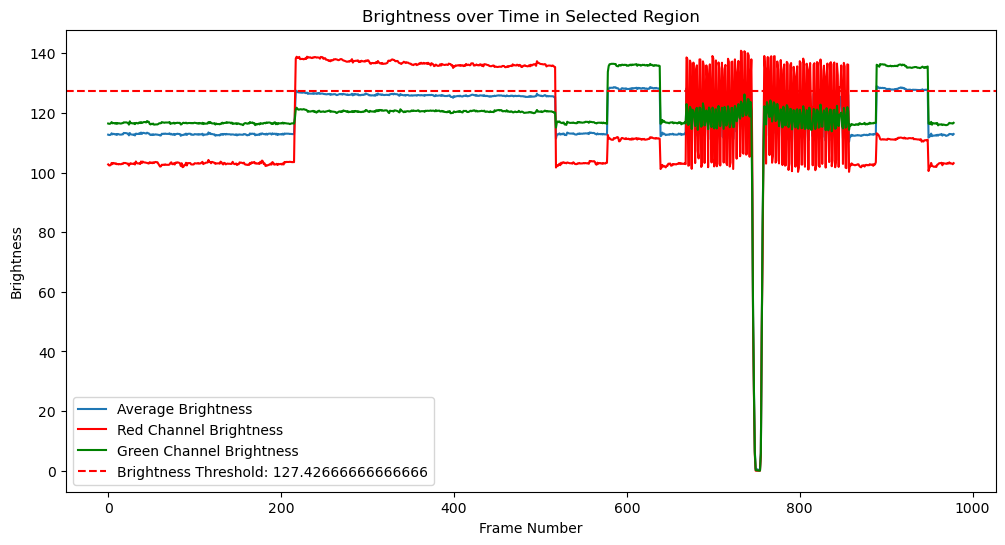

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(brightness_values, label='Average Brightness')
plt.plot(red_values, label='Red Channel Brightness', color='red')
plt.plot(green_values, label='Green Channel Brightness', color='green')
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label=f'Brightness Threshold: {THRESHOLD}')
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.title('Brightness over Time in Selected Region')
plt.legend()
plt.show()

1. find out plateau (plateau_threshold might should be dynamic)
2. trace back the nearest biggest slope

Highest plateau starts at frame 239 with value 138.59477777777778
Maximum slope change near highest plateau at frame 229


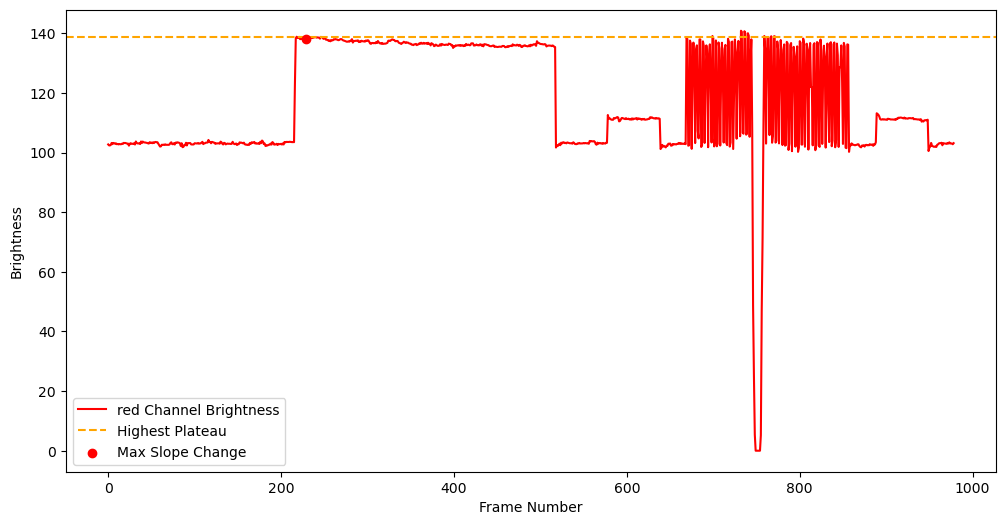

In [29]:
import numpy as np
import matplotlib.pyplot as plt

plateau_threshold = 5
slope_threshold = 5

window_size = 10
smoothed_red = np.convolve(red_values, np.ones(window_size)/window_size, mode='valid')

plateau_mask = np.abs(np.diff(smoothed_red)) < plateau_threshold
plateau_regions = np.where(plateau_mask)[0] + 1

if len(plateau_regions) > 0:
    highest_plateau_idx = np.argmax(smoothed_red[plateau_regions])
    highest_plateau_start = plateau_regions[highest_plateau_idx]
    highest_plateau_value = smoothed_red[highest_plateau_start]
    print(f"Highest plateau starts at frame {highest_plateau_start} with value {highest_plateau_value}")
else:
    print("No plateau found")

red_slope = np.diff(red_values)

slope_region_start = max(0, highest_plateau_start - window_size)
slope_region_end = min(len(red_slope), highest_plateau_start + window_size)

max_slope_idx = np.argmax(np.abs(red_slope[slope_region_start:slope_region_end]))
max_slope_frame = slope_region_start + max_slope_idx

print(f"Maximum slope change near highest plateau at frame {max_slope_frame}")

plt.figure(figsize=(12, 6))
plt.plot(red_values, color='red', label='red Channel Brightness')
plt.axhline(y=highest_plateau_value, color='orange', linestyle='--', label='Highest Plateau')
plt.scatter(max_slope_frame, red_values[max_slope_frame], color='red', label='Max Slope Change', zorder=5)
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.legend()
plt.show()



In [ ]:
green_start_time = max_slope_frame+1

# Check the blinking freq
this camera has Afterimage

# Read the TRC

In [44]:
import pandas as pd
try:
    trc_data = pd.read_csv(trc_file_path)
except pd.errors.ParserError:
    print("pandas_error")
    with open(trc_file_path, 'r') as file:
        trc_data = file.read()

trc_data

,PathFileType\t4\t(X/Y/Z)\tpath1_06_0-979.trc
0,DataRate\tCameraRate\tNumFrames\tNumMarkers\tU...
1,30\t30\t979\t22\tm\t30\t0\t979
2,Frame#\tTime\tHip\t\t\tRHip\t\t\tRKnee\t\t\tRA...
3,\t\tX1\tY1\tZ1\tX2\tY2\tZ2\tX3\tY3\tZ3\tX4\tY4...
4,1\t0.0333333333333333\t-1.7806343853012865\t0....
...,...
978,975\t32.5\t3.5551074217574063\t0.7779513991250...
979,976\t32.53333333333333\t3.5551074217574063\t0....
980,977\t32.56666666666667\t3.5551074217574063\t0....
981,978\t32.6\t3.5551074217574063\t0.7779513991250...


In [45]:
with open(trc_file_path, 'r') as file:
    trc_header = [next(file) for _ in range(4)]

camera_info_header = trc_header[1].strip().split('\t')
camera_info_values = trc_header[2].strip().split('\t')
camera_info = dict(zip(camera_info_header, camera_info_values))
camera_info

{'DataRate': '30',
 'CameraRate': '30',
 'NumFrames': '979',
 'NumMarkers': '22',
 'Units': 'm',
 'OrigDataRate': '30',
 'OrigDataStartFrame': '0',
 'OrigNumFrames': '979'}

In [46]:
header_line = trc_header[3].strip().split('\t')
cleaned_header = [col for col in header_line if col != '']
column_names = ['Frame#', 'Time'] + [f'{marker}_{axis}' for marker in cleaned_header[2:] for axis in ['X', 'Y', 'Z']]

In [47]:
trc_data = pd.read_csv(trc_file_path, sep='\t', skiprows=5, header=None)
trc_data.columns = column_names[:len(trc_data.columns)]
print(trc_data.columns)
trc_data

Index(['Frame#', 'Time', 'Hip_X', 'Hip_Y', 'Hip_Z', 'RHip_X', 'RHip_Y',
       'RHip_Z', 'RKnee_X', 'RKnee_Y', 'RKnee_Z', 'RAnkle_X', 'RAnkle_Y',
       'RAnkle_Z', 'RBigToe_X', 'RBigToe_Y', 'RBigToe_Z', 'RSmallToe_X',
       'RSmallToe_Y', 'RSmallToe_Z', 'RHeel_X', 'RHeel_Y', 'RHeel_Z', 'LHip_X',
       'LHip_Y', 'LHip_Z', 'LKnee_X', 'LKnee_Y', 'LKnee_Z', 'LAnkle_X',
       'LAnkle_Y', 'LAnkle_Z', 'LBigToe_X', 'LBigToe_Y', 'LBigToe_Z',
       'LSmallToe_X', 'LSmallToe_Y', 'LSmallToe_Z', 'LHeel_X', 'LHeel_Y',
       'LHeel_Z', 'Neck_X', 'Neck_Y', 'Neck_Z', 'Head_X', 'Head_Y', 'Head_Z',
       'Nose_X', 'Nose_Y', 'Nose_Z', 'RShoulder_X', 'RShoulder_Y',
       'RShoulder_Z', 'RElbow_X', 'RElbow_Y', 'RElbow_Z', 'RWrist_X',
       'RWrist_Y', 'RWrist_Z', 'LShoulder_X', 'LShoulder_Y', 'LShoulder_Z',
       'LElbow_X', 'LElbow_Y', 'LElbow_Z', 'LWrist_X', 'LWrist_Y', 'LWrist_Z'],
      dtype='object')


,Frame#,Time,Hip_X,Hip_Y,Hip_Z,RHip_X,RHip_Y,RHip_Z,RKnee_X,RKnee_Y,...,RWrist_Z,LShoulder_X,LShoulder_Y,LShoulder_Z,LElbow_X,LElbow_Y,LElbow_Z,LWrist_X,LWrist_Y,LWrist_Z
0,1,0.033333,-1.780634,0.784970,0.280462,-1.80900,0.771000,0.356929,-1.875776,0.441877,...,0.476982,-1.790084,1.321955,0.079260,-1.837352,1.016351,0.125695,-1.796945,0.798145,0.087102
1,2,0.066667,-1.780634,0.784970,0.280462,-1.80900,0.771000,0.356929,-1.875776,0.441877,...,0.476982,-1.790084,1.321955,0.079260,-1.837352,1.016351,0.125695,-1.796945,0.798145,0.087102
2,3,0.100000,-1.780634,0.784970,0.280462,-1.80900,0.771000,0.356929,-1.875776,0.441877,...,0.476982,-1.790084,1.321955,0.079260,-1.837352,1.016351,0.125695,-1.796945,0.798145,0.087102
3,4,0.133333,-1.780634,0.784970,0.280462,-1.80900,0.771000,0.356929,-1.875776,0.441877,...,0.476982,-1.790084,1.321955,0.079260,-1.837352,1.016351,0.125695,-1.796945,0.798145,0.087102
4,5,0.166667,-1.780634,0.784970,0.280462,-1.80900,0.771000,0.356929,-1.875776,0.441877,...,0.476982,-1.790084,1.321955,0.079260,-1.837352,1.016351,0.125695,-1.796945,0.798145,0.087102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,975,32.500000,3.555107,0.777951,0.449376,3.57699,0.749102,0.523838,3.596104,0.410171,...,0.585536,3.501770,1.288681,0.271529,3.558763,1.009748,0.308653,3.648151,0.778652,0.311757
975,976,32.533333,3.555107,0.777951,0.449376,3.57699,0.749102,0.523838,3.596104,0.410171,...,0.585536,3.501770,1.288681,0.271529,3.558763,1.009748,0.308653,3.648151,0.778652,0.311757
976,977,32.566667,3.555107,0.777951,0.449376,3.57699,0.749102,0.523838,3.596104,0.410171,...,0.585536,3.501770,1.288681,0.271529,3.558763,1.009748,0.308653,3.648151,0.778652,0.311757
977,978,32.600000,3.555107,0.777951,0.449376,3.57699,0.749102,0.523838,3.596104,0.410171,...,0.585536,3.501770,1.288681,0.271529,3.558763,1.009748,0.308653,3.648151,0.778652,0.311757


In [48]:
trc_data.iloc[216]

Frame#      217.000000
Time          7.233333
Hip_X        -1.780634
Hip_Y         0.784970
Hip_Z         0.280462
               ...    
LElbow_Y      1.016351
LElbow_Z      0.125695
LWrist_X     -1.796945
LWrist_Y      0.798145
LWrist_Z      0.087102
Name: 216, Length: 68, dtype: float64

979


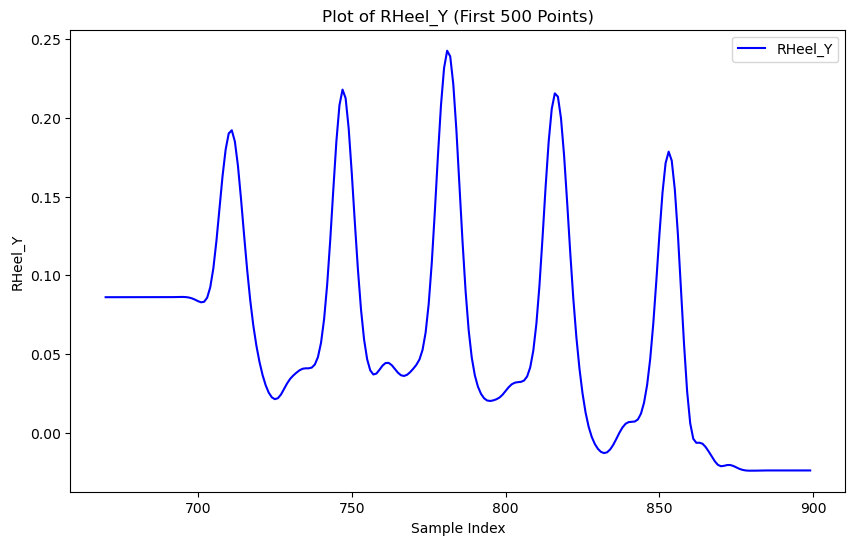

In [49]:
print(len(trc_data['RHeel_Y']))
start_flag = 670
end_flag = 900
rheel_y_sample = trc_data['RHeel_Y'][start_flag:end_flag]

# 繪製 RHeel_Y 數據
plt.figure(figsize=(10, 6))
plt.plot(rheel_y_sample.index, rheel_y_sample, label='RHeel_Y', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('RHeel_Y')
plt.title('Plot of RHeel_Y (First 500 Points)')
plt.legend()
plt.show()

In [50]:
from EMG_class import EMG_DATA
emg_data= EMG_DATA(base_path)
emg_data.read_emg_file(0)
# emg_data.process_data()
# emg_data.plot_emg("LTA", 0, 40.24, show_processed=False)

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF,Event Id,Event Date,Event Duration,Software Marker,Software Marker Name
0,0.000,1773369,-2630.0,-3901.41,9408.65,5348.06,-1611.34,2079.47,1397.03,6795.29,,,,,
1,0.001,1773370,-2631.09,-3879.42,9409.46,5356.1,-1612.02,2079.29,1396.66,6794.71,,,,,
2,0.002,1773371,-2630.85,-3853.26,9410.26,5361.77,-1612.75,2079.22,1396.51,6794.03,,,,,
3,0.003,1773372,-2628.77,-3821.47,9410.99,5363.59,-1613.56,2079.34,1396.7,6793.23,,,,,
4,0.004,1773373,-2625.55,-3786.7,9411.55,5361.51,-1614.47,2079.68,1397.17,6792.33,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40245,40.245,1813614,-2421.54,-3706.68,8886.32,5237.86,-1871.69,2373.16,1359.81,6672.87,,,,,
40246,40.246,1813615,-2426.1,-3724.01,8823.12,5240.08,-1864.64,2370.37,1357.15,6670.79,,,,,
40247,40.247,1813616,-2425.56,-3737.57,8804.16,5242.42,-1859.39,2367.17,1356.78,6669.38,,,,,
40248,40.248,1813617,-2420.36,-3743.05,8832.29,5244.59,-1856.05,2363.84,1358.52,6668.78,,,,,


In [51]:
emg_data.display_event_id_data()

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF,Event Id,Event Date,Event Duration,Software Marker,Software Marker Name
9664,9.664,1783033,-2952.63,-3743.94,9307.83,5408.34,-1735.21,2265.16,1332.86,6872.33,130,9.664,0,,
19673,19.673,1793042,-3190.47,-3830.57,9297.91,5319.89,-1883.68,2424.38,1388.61,6652.25,131,19.673,0,,
21691,21.691,1795060,-2257.22,-3713.24,9278.01,5271.05,-1916.23,2403.42,1379.47,6537.11,140,21.691,0,,
23704,23.704,1797073,-2564.78,-3858.33,9270.84,5244.75,-1672.13,2328.85,1367.76,6735.28,141,23.704,0,,
24711,24.711,1798080,-2715.25,-3926.2,9249.83,5225.37,-1736.42,2350.64,1306.07,6773.7,130,24.711,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30939,30.939,1804308,-2482.1,-4079.18,9253.56,5356.11,-1932.68,2714.35,1148.24,6757.6,0,30.939,0,,
31001,31.001,1804370,-2483.06,-4039.2,9309.0,5296.19,-1915.67,2819.83,1156.58,6901.6,131,31.001,0,,
31002,31.002,1804371,-2472.41,-4046.99,9300.11,5293.5,-1899.86,2808.91,1156.14,6901.57,0,31.002,0,,
32003,32.003,1805372,-2534.95,-3893.73,9255.13,5287.19,-1599.17,2440.94,1261.7,6562.42,140,32.003,0,,


In [52]:
# first_event_index = emg_data.get_event_id_indices()[0]
# print(first_event_index)
# emg_data.our_data = emg_data.our_data.iloc[first_event_index:]
# emg_data.our_data

In [53]:
emg_data_after_first_event = emg_data.process_data(normalize=True)

In [54]:
emg_data_after_first_event

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF
0,0.000,1773369.0,0.007423,0.054661,0.000013,0.019155,0.008763,0.003403,0.015481,0.005793
1,0.001,1773370.0,0.007758,0.054903,0.000217,0.019319,0.008693,0.003442,0.015426,0.005853
2,0.002,1773371.0,0.008096,0.055145,0.000422,0.019482,0.008623,0.003480,0.015370,0.005913
3,0.003,1773372.0,0.008435,0.055386,0.000626,0.019644,0.008553,0.003519,0.015315,0.005972
4,0.004,1773373.0,0.008776,0.055626,0.000830,0.019806,0.008483,0.003557,0.015261,0.006031
...,...,...,...,...,...,...,...,...,...,...
40245,40.245,1813614.0,0.037960,0.108698,0.338682,0.042156,0.056032,0.032876,0.122397,0.027121
40246,40.246,1813615.0,0.037960,0.108696,0.338684,0.042156,0.056031,0.032876,0.122395,0.027121
40247,40.247,1813616.0,0.037960,0.108695,0.338686,0.042156,0.056030,0.032875,0.122393,0.027120
40248,40.248,1813617.0,0.037960,0.108693,0.338688,0.042155,0.056029,0.032875,0.122391,0.027120


In [60]:
trc_start_time = trc_data['Time'].min()
trc_end_time = trc_data['Time'].max()
emg_start_time = emg_data_after_first_event.iloc[0]["Timestamp"]
emg_end_time = emg_data_after_first_event.iloc[-1]["Timestamp"]
print(f"TRC Data Time Range: {trc_start_time} to {trc_end_time}")
print(f"EMG Data Time Range: {emg_start_time} to {emg_end_time}")

KeyError: 'Time'

In [56]:
float(emg_end_time)-float(emg_start_time)

40.249

In [57]:
print(len(trc_data))
print(len(emg_data_after_first_event))

979
40250


0.0333333333333333


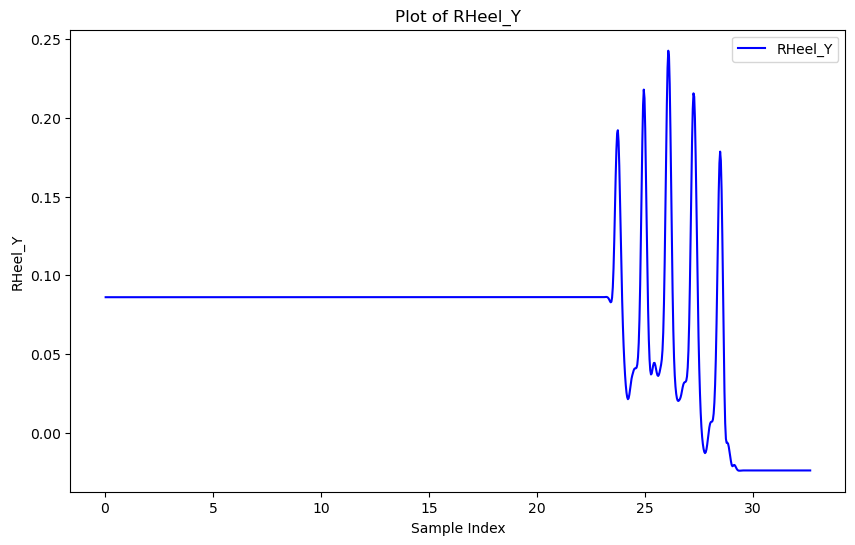

In [58]:
start_flag_external = trc_data['Time'].min()
print(start_flag_external)
end_flag_external = min(trc_end_time, emg_end_time)
plt.figure(figsize=(10, 6))
plt.plot(trc_data['Time'], trc_data['RHeel_Y'], label='RHeel_Y', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('RHeel_Y')
plt.title('Plot of RHeel_Y')
plt.legend()
plt.show()

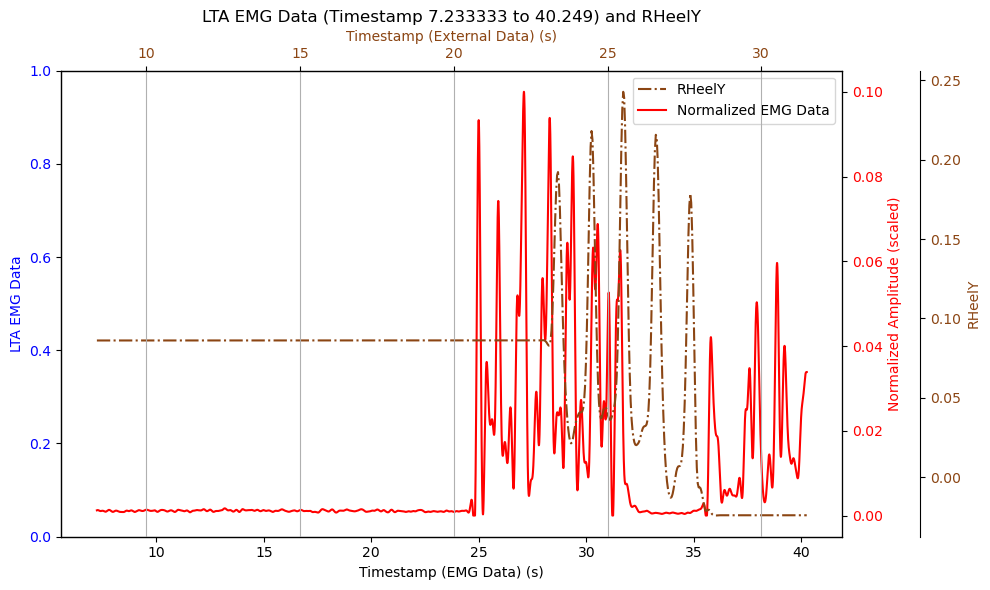

In [59]:
trc_data.set_index('Time', inplace=True)
additional_data = {
    'data': trc_data['RKnee_Y'], 
    'label': 'RHeelY',
    'color': 'saddlebrown'
}

emg_data.plot_emg(
    muscle_name='RTA', 
    start_flag= 7.233333, 
    end_flag=emg_end_time, 
    show_raw=False,
    show_processed=False, 
    show_envelope_raw=False, 
    show_normalized=True,
    additional_start_flag= 7.233333,
    additional_end_flag=end_flag_external,
    additional_data=additional_data
)


In [8]:
import numpy as np
import os
import glob
base_path = '../../mocap_EMG_EEG_data/data_An_Yu/path1_06'
npz_file_path = glob.glob(os.path.join(base_path, 'opensim', '*.npz'))[0]
sync_marker = np.load(npz_file_path)
sync_marker.files
sync_timeline = sync_marker['sync_timeline']
marker = sync_marker['marker']

In [10]:
marker

array([-1], dtype=int32)